## OUTDATED: A1/IC pupil/behavior paper
by DS, ZS, CH, SVD

#### 2018/12 written by DS
**2019/07/23 OUTDATED**

Batches:
* **d_AC_307** DS, SU and MU, onBF and offBF
* **d_IC_309** DS, SU and MU, onBF and offBF

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sci
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

from nems_lbhb.pupil_behavior_scripts.mod_per_state import get_model_results_per_state_model
from nems_lbhb.pupil_behavior_scripts.mod_per_state import aud_vs_state
from nems_lbhb.pupil_behavior_scripts.mod_per_state import hlf_analysis
from nems_lbhb.stateplots import model_per_time_wrapper, beta_comp

%matplotlib inline
os.getcwd()

color_b = '#82418B' #dark purple 
color_p = '#2E7E3E' #dark green

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 60)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2019-01-21 181144.log
[nems_web INFO] No value specified for: DEBUG. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: CSRF_ENABLED. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: CSRF_SESSION_KEY. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: SECRET_KEY. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: PORT. Using default value in nems_web.configs.defaults


Load 307 (A1) and 309 (IC) dataframes

In [2]:
# RUN IF CONNECTED TO SERVER

# A1 SUA+MUA: pup vs. beh 307 per state dataframe
#batch = 307  # A1 SUA and MUA
#state_list = ['st.pup0.beh0','st.pup0.beh','st.pup.beh0','st.pup.beh']
#basemodel = "-ref-psthfr.s_sdexp.S"
#d_pb307 = get_model_results_per_state_model(batch=batch, state_list=state_list, basemodel=basemodel)

In [3]:
# RUN IF NOT CONNECTED TO SERVER 
# A1 SUA+MUA: pup vs. beh 307 per state 
d_pb307 = pd.read_csv('d_307_pb.csv') #model rerun November 8 sdexp.S

In [4]:
d_pb307 = d_pb307.drop(['Unnamed: 0'], axis=1)

# Add extra metadata columns 
d_pb307['R2'] = d_pb307['r']**2 * np.sign(d_pb307['r'])
d_pb307['area'] = 'A1'
d_pb307['sign'] = 'TBD'
d_pb307['experimenter'] = 'DS'
d_pb307['onBF'] = 'TBD'
d_pb307['SU'] = False
d_pb307.loc[d_pb307['isolation']>=90.0, 'SU'] = True
d_pb307['animal'] = d_pb307['cellid'].map(lambda x: x[:3])
d_pb307['task'] = 'TIN'

In [5]:
## RUN IF CONNECTED TO SERVER

# IC SUA+MUA: pup vs. beh 307 per state dataframe
#batch = 309  # IC SUA and MUA
#state_list = ['st.pup0.beh0','st.pup0.beh','st.pup.beh0','st.pup.beh']
#basemodel = "-ref-psthfr.s_stategain.S"
#d_pb309 = get_model_results_per_state_model(batch=batch, state_list=state_list, basemodel=basemodel)

In [6]:
# RUN IF NOT CONNECTED TO SERVER 
# IC SUA+MUA: pup vs. beh 309 per state dataframe
d_pb309 = pd.read_csv('d_309_pb.csv')

In [7]:
d_pb309 = d_pb309.drop(['Unnamed: 0'], axis=1)

# Add extra metadata columns 
d_pb309['R2'] = d_pb309['r']**2 * np.sign(d_pb309['r'])
d_pb309['onBF'] = 'TBD'
d_pb309['experimenter'] = 'DS'
d_pb309['sign'] = 'TBD'
d_pb309['animal'] = d_pb309['cellid'].map(lambda x: x[:3])
d_pb309['task'] = 'TIN'
d_pb309.loc[d_pb309['animal']=='ley', 'task'] = 'TvN'
d_pb309['SU'] = False
d_pb309.loc[d_pb309['isolation']>=90.0, 'SU'] = True

In [8]:
# load csv with info about ICC and ICX
d_IC_area = pd.read_csv('IC_cells_area.csv')

In [9]:
d_pb309 = pd.merge(left=d_pb309, right=d_IC_area, how='outer', on='cellid')

In [10]:
# ensure there are no nans 
nan_rows = d_pb309[d_pb309['area'].isnull()]
nan_rows

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,R2,onBF,experimenter,sign,animal,task,SU,area


Load 307 and 309 strf dataframes

In [11]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_307.csv')
d_307_strf = pd.read_csv('tuning_info_batch_307.csv')
d_307_strf = d_307_strf.drop(['Unnamed: 43'], axis=1)

In [12]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_307.csv')
d_309_strf = pd.read_csv('tuning_info_batch_309.csv')
d_309_strf = d_309_strf.drop(['Unnamed: 43'], axis=1)

Concatenate 307 and 309 data dataframes

In [13]:
d_307_309 = pd.concat([d_pb307, d_pb309], sort=False)

Concatenate 307 and 309 strf dataframes

In [14]:
d_307_309_strf = pd.concat([d_307_strf, d_309_strf], sort=False)

Merge it all

In [15]:
df = pd.merge(left=d_307_309, right=d_307_309_strf, how='outer', on='cellid')

In [16]:
def fix_TBD_onBF(df):
    '''This function takes the monster dataframe and adds True to the column 'onBF' when 'ACTIVE_1_tardist' is
    within 0.5 --> half an octave between unit BF and target frequency in ACTIVE 1'''
    BF_TBD = (df['onBF']=='TBD')
    df.loc[BF_TBD, 'onBF'] = df.loc[BF_TBD, 'ACTIVE_1_tardist'].map(lambda x: abs(x)<=0.5)
    return df

In [17]:
df['onBF'].value_counts()

TBD    2340
Name: onBF, dtype: int64

In [18]:
df = fix_TBD_onBF(df)

In [19]:
df['onBF'].value_counts()

False    1428
True      912
Name: onBF, dtype: int64

In [20]:
df['area'].value_counts()

A1     1548
ICX     576
ICC     216
Name: area, dtype: int64

In [21]:
df.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,R2,area,sign,experimenter,onBF,SU,animal,task,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,...,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
0,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,baseline,NaN,95.4293,0.452884,0.025611,0.026288,1.022688,baseline,0.205103,A1,TBD,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,...,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,pupil,0.010855,95.4293,0.452884,0.025611,0.013340,0.027984,pupil,0.205103,A1,TBD,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,...,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,active,-0.000702,95.4293,0.452884,0.025611,0.031175,0.021035,active,0.205103,A1,TBD,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,...,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,baseline,NaN,95.4293,0.452708,0.025073,0.047462,0.996078,baseline,0.204945,A1,TBD,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,...,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,pupil,0.013942,95.4293,0.452708,0.025073,0.014610,0.060707,pupil,0.204945,A1,TBD,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,...,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Example cells TAR010c-27-2 (A1 behavior cell) and TAR010c-06-1 (A1 pupil cell)
df.loc[df['cellid']=='TAR010c-27-2']

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,R2,area,sign,experimenter,onBF,SU,animal,task,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,...,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
420,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,baseline,NaN,95.0,0.408684,0.020415,-0.009625,1.018744,baseline,0.167023,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,pupil,0.000654,95.0,0.408684,0.020415,-0.061233,0.060229,pupil,0.167023,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,active,0.000077,95.0,0.408684,0.020415,-0.089852,0.345671,active,0.167023,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,baseline,NaN,95.0,0.547967,0.024350,1.410993,0.051466,baseline,0.300268,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,pupil,0.170756,95.0,0.547967,0.024350,-0.019316,0.019379,pupil,0.300268,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,active,0.365985,95.0,0.547967,0.024350,2.217914,3.225629,active,0.300268,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,TAR010c-27-2,psth.fs20.pup-ld-st.pup.beh0-ref-psthfr.s_sdex...,st.pup.beh0,baseline,NaN,95.0,0.469955,0.022545,3.175568,3.350028,baseline,0.220858,A1,TBD,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,...,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,TAR010c-27-2,psth.fs20.pup-ld-st.pup.beh0-ref-psthfr.s_sdex...,st.pup

In [96]:
# creating subdf with only rows that match conditions
is_active = (df['state_chan']=='active')
full_model = (df['state_sig']=='st.pup.beh')
null_model = (df['state_sig']=='st.pup0.beh0')
part_beh_model = (df['state_sig']=='st.pup0.beh')
part_pup_model = (df['state_sig']=='st.pup.beh0')

# adding new colums to df with differences of R2 full-null, MI full-partial pup, and MI partial beh-null
for cellid in df['cellid'].unique():
    mask_for_cellid = df['cellid']==cellid
    active_full = df[is_active & full_model & mask_for_cellid]
    active_null = df[is_active & null_model & mask_for_cellid]
    active_part_beh = df[is_active & part_beh_model & mask_for_cellid]
    active_part_pup = df[is_active & part_pup_model & mask_for_cellid]
    if len(active_full) != 1:
        print(f'WARNING: active full is not one for {cellid}')
        continue
    if len(active_null) != 1:
        print(f'WARNING: active null is not one for {cellid}')
        continue
    if len(active_part_beh) != 1:
        print(f'WARNING: active part beh is not one for {cellid}')
        continue
    if len(active_part_pup) != 1:
        print(f'WARNING: active part pup is not one for {cellid}')
        continue
    df.loc[mask_for_cellid, 'R2_diff'] = active_full.iloc[0]['R2']-active_null.iloc[0]['R2']
    df.loc[mask_for_cellid, 'MIbeh_only'] = active_part_beh.iloc[0]['MI']-active_null.iloc[0]['MI']
    df.loc[mask_for_cellid, 'MIbeh_unique'] = active_full.iloc[0]['MI']-active_part_pup.iloc[0]['MI']
    df.loc[mask_for_cellid, 'R2beh_unique'] = active_full.iloc[0]['R2']-active_part_pup.iloc[0]['R2']
    df.loc[mask_for_cellid, 'R2pup_unique'] = active_full.iloc[0]['R2']-active_part_beh.iloc[0]['R2']
    
    # adding new colums to df with significance
    
    r_pup_beh = active_full.iloc[0]['r']
    r_pup_beh0 = active_part_pup.iloc[0]['r']
    r_pup0_beh = active_part_beh.iloc[0]['r']
    rse_pup_beh = active_full.iloc[0]['r_se']
    rse_pup_beh0 = active_part_pup.iloc[0]['r_se']
    rse_pup0_beh = active_part_beh.iloc[0]['r_se']
    r_pup0_beh0 = active_null.iloc[0]['r']
    rse_pup0_beh0 = active_null.iloc[0]['r_se']
    
    
    df.loc[mask_for_cellid, 'sig_ubeh'] = (r_pup_beh - r_pup_beh0) > (rse_pup_beh + rse_pup_beh0)
    df.loc[mask_for_cellid, 'sig_upup'] = (r_pup_beh - r_pup0_beh) > (rse_pup_beh + rse_pup0_beh)
    df.loc[mask_for_cellid, 'sig_state'] = (r_pup_beh - r_pup0_beh0) > (rse_pup_beh + rse_pup0_beh0)
    

**Find A1 units for which the unique contribution of behavior is significant**  PURPLE  
sig_ubeh = r_pup_beh - r_pup_beh0 > rse_pup_beh + rse_pup_beh0 where 'r' is Pearson's correlation  

**Find A1 units for which the unique contribution of pupil is significant** GREEN  
sig_upup = r_pup_beh - r_pup0_beh > rse_pup_beh + rse_pup0_beh where 'r' is Pearson's correlation  

**Find A1 units for which the full state model is significant better than the null model (ambiguous)**   Dark Black
sig_state = r_pup_beh - r_pup0_beh0 > rse_pup_beh + rse_pup0_beh0 where 'r' is Pearson's correlation

sig_both when both sig_ubeh and sig_upup is true

not significant



In [24]:
# creating list of booleans to mask A1, IC, onBF and offBF out of big df
A1 = df['area']=='A1'
ICC = df['area']=='ICC'
ICX = df['area']=='ICX'
onBF = df['onBF']==True
offBF = df['onBF']==False
SU = df['SU']==True
sig_ubeh = df['sig_ubeh']==True
sig_upup = df['sig_upup']==True
sig_both = sig_ubeh & sig_upup
sig_state = df['sig_state']==True

In [95]:
def scat_states(x_model, 
                y_model, 
                beh_state, 
                area, 
                sig_list, 
                x_column, 
                y_column,
                color_list,
                highlight_cellids={},
                hue=False,
                save=False,
                xlabel=None,
                ylabel=None,
                title=None,
                xlim=None, 
                ylim=None):
    
    '''This function makes a scatter plots of identified arguments. 
    sig_list = ~sig_state, sig_state, sig_ubeh, sig_upup, sig_both]
    color_list = ['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000']
    TODO: make sig_list and color_list into a dict
    highlight_cellid has to be a dict 'cellid':'color' 
    add hue if istead of plotting color for stat sign units,
    you want to plot different color based on values in a column (eg onBF)'''
    
    
    plt.figure(figsize=(6,6))
    
    # need a slope and c to fix the position of line
    if xlim is not None:
        xlim = xlim 
        ylim = ylim
        slope = 1
        c = xlim[0]

        x_min = xlim[0]
        x_max = xlim[1]
        y_min, y_max = c, c + slope*(x_max-x_min)
        plt.plot([x_min, x_max], [y_min, y_max], linewidth=0.5, linestyle='--', color='k')
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

    plt.axvline(0, linestyle='--', linewidth=0.5, color='k')
    plt.axhline(0, linestyle='--', linewidth=0.5, color='k')
  
    
    if area is not ICC:
        marker = 'o'
    else:
        marker = '^'   
        
    if hue:
        sns.scatterplot(x=df.loc[x_model & beh_state & area, x_column].tolist(), 
                        y=df.loc[y_model & beh_state & area, y_column].tolist(), 
                        s = 200, hue = df.loc[x_model & beh_state & area, hue],
                        marker = marker, edgecolors = 'white', linewidth = 0.5)
        
    else:
        # plot not significant units
        plt.scatter(x=df.loc[x_model & beh_state & area & sig_list[0], x_column].tolist(), 
                    y=df.loc[y_model & beh_state & area & sig_list[0], y_column].tolist(), 
                    s = 150, color = color_list[0], marker = marker, edgecolors = 'white', linewidth = 0.5) 
    
        # plot significant state units
        plt.scatter(x=df.loc[x_model & beh_state & area & sig_list[1], x_column].tolist(), 
                    y=df.loc[y_model & beh_state & area & sig_list[1], y_column].tolist(), 
                    s = 200, color = color_list[1], marker = marker, edgecolors = 'white',linewidth = 0.5)

        # plot significant unique behavior
        plt.scatter(x=df.loc[x_model & beh_state & area & sig_list[2], x_column].tolist(), 
                    y=df.loc[y_model & beh_state & area & sig_list[2], y_column].tolist(), 
                    s = 200, color = color_list[2], marker = marker, edgecolors = 'white',linewidth = 0.5)

        # plot significant unique pupil
        plt.scatter(x=df.loc[x_model & beh_state & area & sig_list[3], x_column].tolist(), 
                    y=df.loc[y_model & beh_state & area & sig_list[3], y_column].tolist(), 
                    s = 200, color = color_list[3], marker = marker, edgecolors = 'white', linewidth = 0.5)

        # plot significant unique both
        plt.scatter(x=df.loc[x_model & beh_state & area & sig_list[4], x_column].tolist(), 
                    y=df.loc[y_model & beh_state & area & sig_list[4], y_column].tolist(), 
                    s = 200, color = color_list[4], marker = marker, edgecolors = 'white', linewidth = 0.5)
    
    # plot a cellid (e.g. TAR010c-27-2 (A1 behavior cell) or TAR010c-06-1 (A1 pupil cell)) with special color
    
    if type(highlight_cellids) is not dict:
        raise Exception('highlight_cellids has got to be a dict, woman!')
    else:
        for cellid, color in highlight_cellids.items():
            plt.scatter(x=df.loc[x_model & beh_state & area & (df['cellid']==cellid), x_column].tolist(), 
                        y=df.loc[y_model & beh_state & area & (df['cellid']==cellid), y_column].tolist(), 
                        s = 200, color = color, marker = marker, edgecolors = 'white', linewidth=0.5)

    if save:
        plt.savefig(title+ylabel+xlabel+'.pdf')

In [26]:
def bar_states(x_model, 
               y_model, 
               beh_state, 
               area, 
               sig_list, 
               x_column, 
               y_column,
               color_list,
               save=False,
               xlabel=None,
               ylabel=None,
               title=None,
               xlim=None, 
               ylim=None):

    ind = np.arange(mb.shape[0])
    width=0.8
    #ind = m[:,0]
    p1 = plt.bar(ind, mb[:,0], width=width, color=colors[0])
    p2 = plt.bar(ind, mb[:,1], width=width, bottom=mb[:,0], color=colors[1])
    p3 = plt.bar(ind, mb[:,2], width=width, bottom=mb[:,0]+mb[:,1], color=colors[2])
    plt.legend(('common','p_unique','b_unique'))
    if title is not None:
        plt.title(title)
    plt.xlabel('behavior-independent quintile')
    plt.ylabel('mean r2')

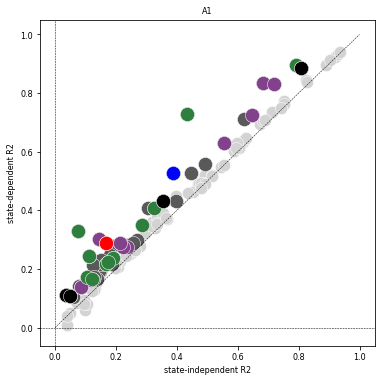

In [87]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=A1, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup, sig_both], 
            x_column='R2',
            y_column='R2', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            highlight_cellids={'TAR010c-27-2':'red', 'TAR010c-06-1':'blue'},
            save=False,
            xlim=(0,1), 
            ylim=(0,1),
            xlabel='state-independent R2',
            ylabel='state-dependent R2',
            title='A1')

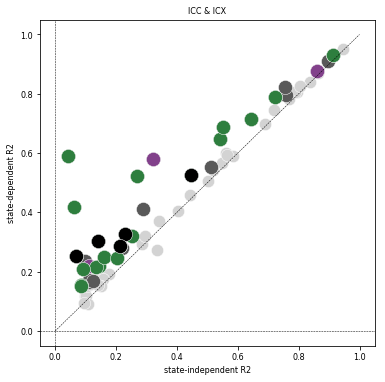

In [82]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=(ICC | ICX), 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup, sig_both], 
            x_column='R2',
            y_column='R2', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlim=(0,1), 
            ylim=(0,1),
            xlabel='state-independent R2',
            ylabel='state-dependent R2',
            title='ICC & ICX')

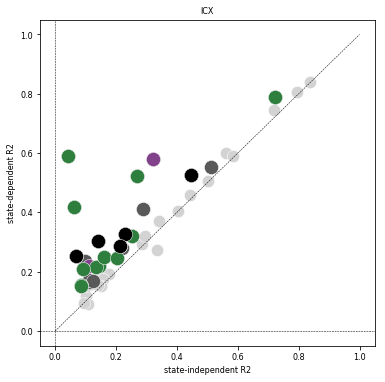

In [29]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=ICX, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup, sig_both], 
            x_column='R2',
            y_column='R2', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlim=(0,1), 
            ylim=(0,1),
            xlabel='state-independent R2',
            ylabel='state-dependent R2',
            title='ICX')

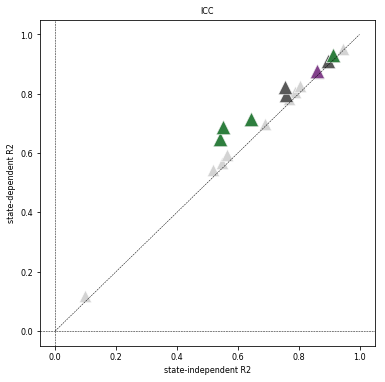

In [30]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=ICC, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup, sig_both], 
            x_column='R2',
            y_column='R2', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlim=(0,1), 
            ylim=(0,1),
            xlabel='state-independent R2',
            ylabel='state-dependent R2',
            title='ICC')

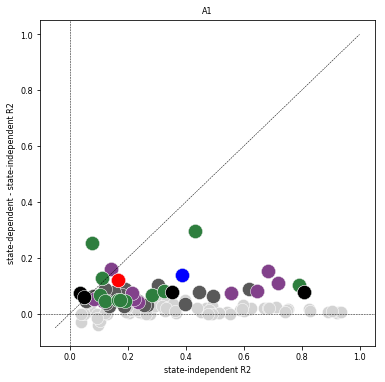

In [83]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=A1, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='R2',
            y_column='R2_diff', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            highlight_cellids={'TAR010c-27-2':'red', 'TAR010c-06-1':'blue'},
            save=False,
            xlabel='state-independent R2',
            ylabel='state-dependent - state-independent R2',
            title='A1',
            xlim=(-0.05,1),
            ylim=(-0.05,1))

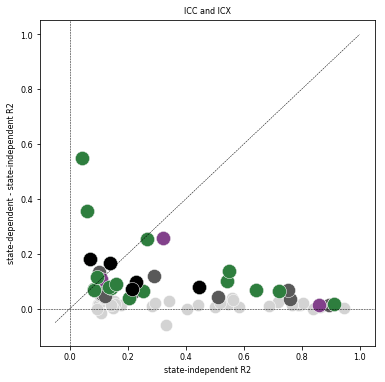

In [32]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=(ICC | ICX), 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup, sig_both], 
            x_column='R2',
            y_column='R2_diff', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlabel='state-independent R2',
            ylabel='state-dependent - state-independent R2',
            title='ICC and ICX',
            xlim=(-0.05,1),
            ylim=(-0.05,1))

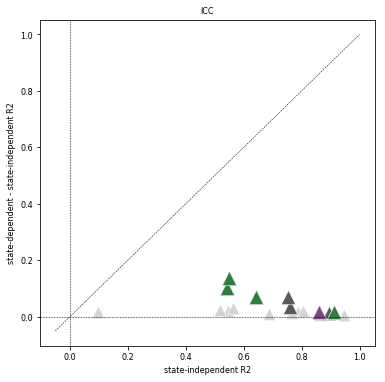

In [33]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=ICC, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='R2',
            y_column='R2_diff', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlabel='state-independent R2',
            ylabel='state-dependent - state-independent R2',
            title='ICC',
            xlim=(-0.05,1),
            ylim=(-0.05,1))

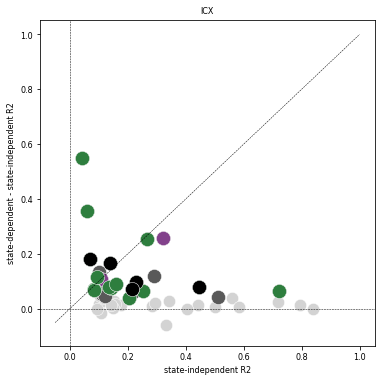

In [34]:
scat_states(x_model=null_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=ICX, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='R2',
            y_column='R2_diff', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlabel='state-independent R2',
            ylabel='state-dependent - state-independent R2',
            title='ICX',
            xlim=(-0.05,1),
            ylim=(-0.05,1))

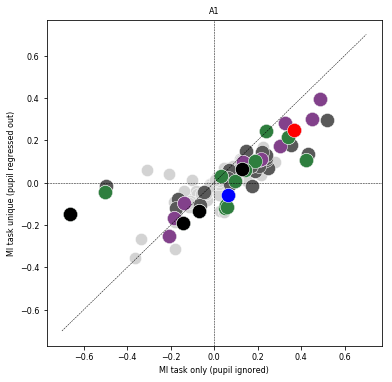

In [85]:
scat_states(x_model=full_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=A1, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='MIbeh_only',
            y_column='MIbeh_unique', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            highlight_cellids={'TAR010c-27-2':'red', 'TAR010c-06-1':'blue'},
            save=False,
            xlabel='MI task only (pupil ignored)',
            ylabel='MI task unique (pupil regressed out)',
            title='A1',
            xlim=(-0.7,0.7),
            ylim=(-0.7,0.7))

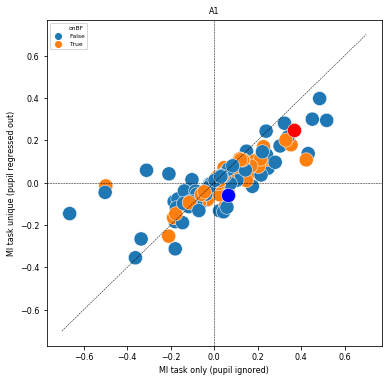

In [92]:
scat_states(x_model=full_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=A1, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='MIbeh_only',
            y_column='MIbeh_unique', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            highlight_cellids={'TAR010c-27-2':'red', 'TAR010c-06-1':'blue'},
            hue='onBF',
            save=False,
            xlabel='MI task only (pupil ignored)',
            ylabel='MI task unique (pupil regressed out)',
            title='A1',
            xlim=(-0.7,0.7),
            ylim=(-0.7,0.7))

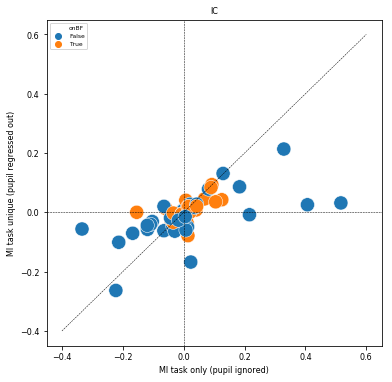

In [94]:
scat_states(x_model=full_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=(ICC | ICX), 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='MIbeh_only',
            y_column='MIbeh_unique', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            hue='onBF',
            save=False,
            xlabel='MI task only (pupil ignored)',
            ylabel='MI task unique (pupil regressed out)',
            title='IC',
            xlim=(-0.4,0.6),
            ylim=(-0.4,0.6))

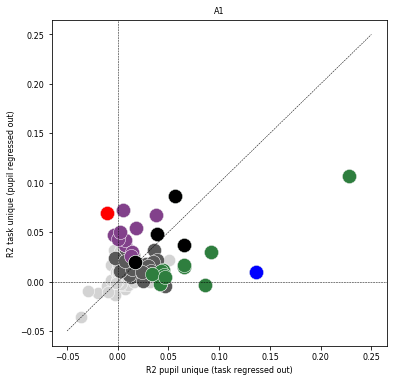

In [103]:
scat_states(x_model=full_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=A1, 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='R2pup_unique',
            y_column='R2beh_unique', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            highlight_cellids={'TAR010c-27-2':'red', 'TAR010c-06-1':'blue'},
            save=False,
            xlabel='R2 pupil unique (task regressed out)',
            ylabel='R2 task unique (pupil regressed out)',
            title='A1',
            xlim=(-0.05,0.25),
            ylim=(-0.05,0.25))



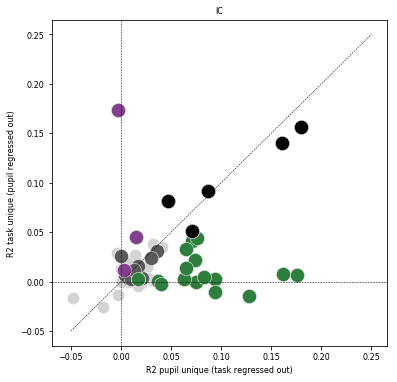

In [104]:
scat_states(x_model=full_model, 
            y_model=full_model, 
            beh_state=is_active, 
            area=(ICC | ICX), 
            sig_list=[~sig_state, sig_state, sig_ubeh, sig_upup,sig_both], 
            x_column='R2pup_unique',
            y_column='R2beh_unique', 
            color_list=['#D3D3D3', '#595959', '#82418B', '#2E7E3E', '#000000'],
            save=False,
            xlabel='R2 pupil unique (task regressed out)',
            ylabel='R2 task unique (pupil regressed out)',
            title='IC',
            xlim=(-0.05,0.25),
            ylim=(-0.05,0.25))

In [35]:
#TODO ---> use scat_states function to plot scatter plots.

0.170926922991 0.0527773374688


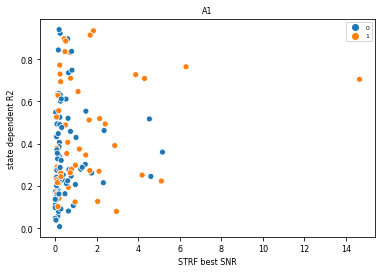

In [36]:
# plot for A1 separating for onBF - full model 
#ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[full_model & is_active & A1])
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df.loc[full_model & is_active & A1,'onBF'].values.astype(int), 
                     data=df[full_model & is_active & A1])
plt.ylabel('state dependent R2')
plt.xlabel('STRF best SNR')
plt.title('A1')
#plt.xlim(0,15)

# quantify correlation between R2 and snr for A1
(cc_A1_full, p_value_A1_full) = sci.stats.pearsonr(df.loc[full_model & is_active & A1, 'bestsnr'], 
                                                   df.loc[full_model & is_active & A1, 'R2'])
print(cc_A1_full, p_value_A1_full)

0.642772996623 5.92776516726e-09


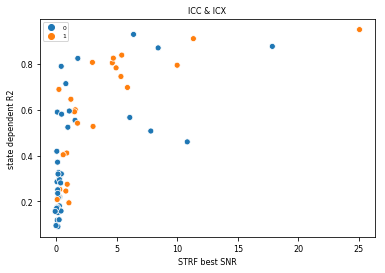

In [37]:
# plot for IC separating for onBF - full model 
#ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[full_model & is_active & IC])
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df.loc[full_model & is_active & (ICC | ICX),'onBF'].values.astype(int), 
                     data=df[full_model & is_active & (ICC | ICX)])
plt.ylabel('state dependent R2')
plt.xlabel('STRF best SNR')
plt.title('ICC & ICX')

# quantify correlation between R2 and snr for IC - full model
(cc_IC_full, p_value_IC_full) = sci.stats.pearsonr(df.loc[full_model & is_active & (ICC | ICX), 'bestsnr'], 
                                                   df.loc[full_model & is_active & (ICC | ICX), 'R2'])
print(cc_IC_full, p_value_IC_full)

0.514047890709 0.000186065588766


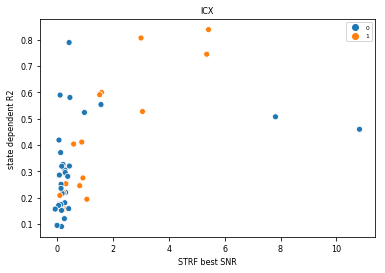

In [38]:
# plot for IC separating for onBF - full model 
#ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[full_model & is_active & IC])
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df.loc[full_model & is_active & ICX,'onBF'].values.astype(int), 
                     data=df[full_model & is_active & ICX])
plt.ylabel('state dependent R2')
plt.xlabel('STRF best SNR')
plt.title('ICX')

# quantify correlation between R2 and snr for IC - full model
(cc_ICX_full, p_value_ICX_full) = sci.stats.pearsonr(df.loc[full_model & is_active & ICX, 'bestsnr'], 
                                                   df.loc[full_model & is_active & ICX, 'R2'])
print(cc_ICX_full, p_value_ICX_full)

0.189301849293 0.0316665198015


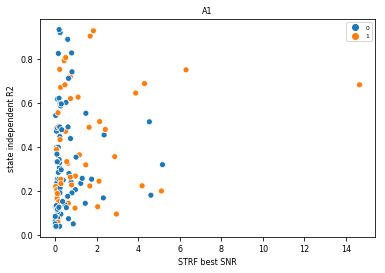

In [39]:
# plot for A1 separating for onBF - null model
#ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[null_model & is_active & A1])
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df.loc[null_model & is_active & A1,'onBF'].values.astype(int), 
                     data=df[null_model & is_active & A1])
plt.ylabel('state independent R2')
plt.xlabel('STRF best SNR')
plt.title('A1')
#plt.xlim(0,15)

# quantify correlation between R2 and snr for A1 - full model
(cc_A1_null, p_value_A1_null) = sci.stats.pearsonr(df.loc[null_model & is_active & A1, 'bestsnr'], 
                                                   df.loc[null_model & is_active & A1, 'R2'])
print(cc_A1_null, p_value_A1_null)

0.641879673168 0.00408162261118


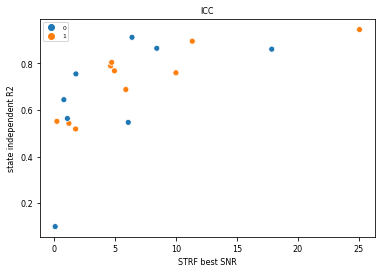

In [40]:
# plot for IC separating for onBF - null model 
#ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[null_model & is_active & IC])
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df.loc[null_model & is_active & ICC,'onBF'].values.astype(int), 
                     data=df[null_model & is_active & ICC])
plt.ylabel('state independent R2')
plt.xlabel('STRF best SNR')
plt.title('ICC')

# quantify correlation between R2 and snr for IC - null model
(cc_ICC_null, p_value_ICC_null) = sci.stats.pearsonr(df.loc[null_model & is_active & ICC, 'bestsnr'], 
                                                   df.loc[null_model & is_active & ICC, 'R2'])
print(cc_ICC_null, p_value_ICC_null)

-0.092551370419 0.296859898786


/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


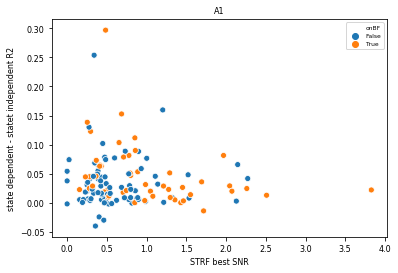

In [41]:
# plot snr vs R2 diff for A1
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active & A1, 'bestsnr']), 
                     y=df.loc[full_model & is_active & A1, 'R2_diff'],
                     hue=df.loc[full_model & is_active & A1, 'onBF'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('STRF best SNR')
plt.title('A1')

# verify if correlation is significant
(cc_R2STRF_A1, p_R2STRF_A1) = sci.stats.pearsonr(df.loc[full_model & is_active & A1, 'bestsnr'],
                                                 df.loc[full_model & is_active & A1, 'R2_diff'])
print(cc_R2STRF_A1, p_R2STRF_A1)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


-0.157728218246 0.0276513764442


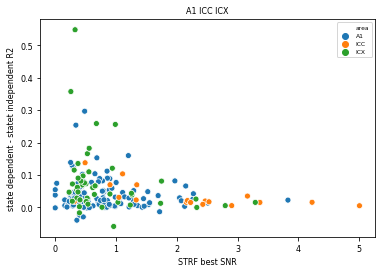

In [42]:
# plot snr vs R2 diff for IC
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active, 'bestsnr']), 
                     y=df.loc[full_model & is_active, 'R2_diff'],
                     hue=df.loc[full_model & is_active, 'area'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('STRF best SNR')
plt.title('A1 ICC ICX')
plt.savefig('DeltaR2_STRF.pdf')

# verify if correlation is significant
(cc_R2STRF, p_R2STRF) = sci.stats.pearsonr(df.loc[full_model & is_active, 'bestsnr'],
                                                 df.loc[full_model & is_active, 'R2_diff'])
print(cc_R2STRF, p_R2STRF)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


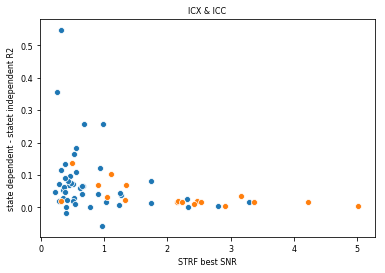

In [43]:
# plot snr vs R2 diff for IC
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active & ICX, 'bestsnr']), 
                     y=df.loc[full_model & is_active & ICX, 'R2_diff'])
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active & ICC, 'bestsnr']), 
                     y=df.loc[full_model & is_active & ICC, 'R2_diff'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('STRF best SNR')
plt.title('ICX & ICC')
plt.savefig('DeltaR2_STRF.pdf')

# verify if correlation is significant
#(cc_R2STRF_ICX, p_R2STRF_ICX) = sci.stats.pearsonr(np.sqrt(abs(df.loc[full_model & is_active & ICX, 'bestsnr'])),
#                                                 df.loc[full_model & is_active & ICX, 'R2_diff'])
#print(cc_R2STRF_ICX, p_R2STRF_ICX)

-0.585760382521 0.0106396802966


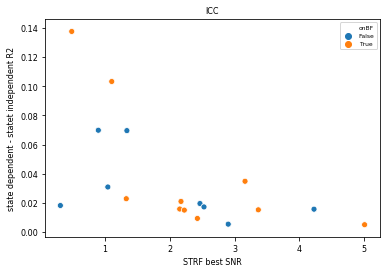

In [44]:
# plot snr vs R2 diff for IC
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active & ICC, 'bestsnr']), 
                     y=df.loc[full_model & is_active & ICC, 'R2_diff'],
                     hue=df.loc[full_model & is_active & ICC, 'onBF'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('STRF best SNR')
plt.title('ICC')

# verify if correlation is significant
(cc_R2STRF_ICC, p_R2STRF_ICC) = sci.stats.pearsonr(np.sqrt(df.loc[full_model & is_active & ICC, 'bestsnr']),
                                                 df.loc[full_model & is_active & ICC, 'R2_diff'])
print(cc_R2STRF_ICC, p_R2STRF_ICC)

-0.0842459254598 0.342506097594


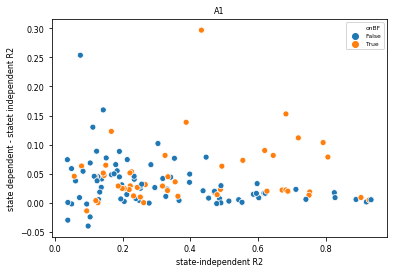

In [45]:
# plot and calculate correlation between state-dependent R2 and state-independent R2 In A1 and IC
ax = sns.scatterplot(x=df.loc[null_model & is_active & A1, 'R2'].tolist(), 
                     y=df.loc[full_model & is_active & A1, 'R2_diff'].tolist(),
                     hue=df.loc[full_model & is_active & A1, 'onBF'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('state-independent R2')
plt.title('A1')
#plt.savefig('R2_state_dep_indep_scatter_A1.pdf')

# verify if correlation is significant
(cc_R2_A1, p_R2_A1) = sci.stats.pearsonr(df.loc[null_model & is_active & A1, 'R2'].tolist(),
                                         df.loc[full_model & is_active & A1, 'R2_diff'].tolist())
print(cc_R2_A1, p_R2_A1)

-0.344065833692 0.00467352208479


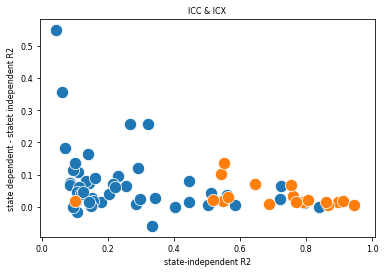

In [46]:
# plot and calculate correlation between state-dependent R2 and state-independent R2 In A1 and ICC
ax = sns.scatterplot(x=df.loc[null_model & is_active & ICX, 'R2'].tolist(), 
                     y=df.loc[full_model & is_active & ICX, 'R2_diff'].tolist(), s = 150)
ax = sns.scatterplot(x=df.loc[null_model & is_active & ICC, 'R2'].tolist(), 
                     y=df.loc[full_model & is_active & ICC, 'R2_diff'].tolist(), s = 150)
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('state-independent R2')
plt.title('ICC & ICX')
plt.savefig('DeltaR2_R2ind_IC.pdf')

#verify if correlation is significant
(cc_R2_IC, p_R2_IC) = sci.stats.pearsonr(df.loc[null_model & is_active & (ICC | ICX), 'R2'].tolist(),
                                          df.loc[full_model & is_active & (ICC | ICX), 'R2_diff'].tolist())
print(cc_R2_IC, p_R2_IC)

In [47]:
print(df.loc[null_model & is_active & ICX, 'R2'].median())
print(df.loc[null_model & is_active & ICC, 'R2'].median())
print(df.loc[full_model & is_active & ICX, 'R2_diff'].median())
print(df.loc[full_model & is_active & ICC, 'R2_diff'].median())

0.16898138259004464
0.7571516602612043
0.047068928876634705
0.01881035198634389


-0.309217293067 0.0324707457338


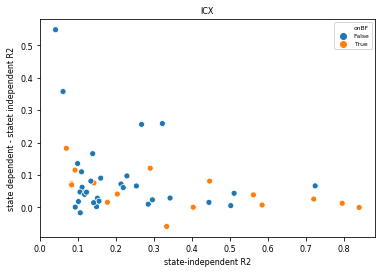

In [48]:
# plot and calculate correlation between state-dependent R2 and state-independent R2 In A1 and ICX
ax = sns.scatterplot(x=df.loc[null_model & is_active & ICX, 'R2'].tolist(), 
                     y=df.loc[full_model & is_active & ICX, 'R2_diff'].tolist(),
                     hue=df.loc[full_model & is_active & ICX, 'onBF'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('state-independent R2')
plt.title('ICX')
#plt.savefig('R2_state_dep_indep_scatter_ICX.pdf')

# verify if correlation is significant
(cc_R2_ICX, p_R2_ICX) = sci.stats.pearsonr(df.loc[null_model & is_active & ICX, 'R2'].tolist(),
                                         df.loc[full_model & is_active & ICX, 'R2_diff'].tolist())
print(cc_R2_ICX, p_R2_ICX)

In [49]:
len(df.loc[null_model & is_active & A1, 'R2'])

129

In [50]:
# x_A1=df.loc[null_model & is_active & A1, 'R2']
# y_A1=df.loc[full_model & is_active & A1, 'R2_diff']
# plt.scatter(x_A1,y_A1)
# plt.ylabel('state dependent - statet independent R2')
# plt.xlabel('state-independent R2')
# plt.title('A1')
# # verify if correlation is significant
# (cc_R2_A1, p_R2_A1) = sci.stats.pearsonr(x_A1, y_A1)
# print(cc_R2_A1, p_R2_A1)

In [51]:
# x_IC=df.loc[null_model & is_active & IC, 'R2']
# y_IC=df.loc[full_model & is_active & IC, 'R2_diff']
# plt.scatter(x_IC,y_IC)
# plt.ylabel('state dependent - statet independent R2')
# plt.xlabel('state-independent R2')
# plt.title('IC')
# # verify if correlation is significant
# (cc_R2_IC, p_R2_A1) = sci.stats.pearsonr(x_IC, y_IC)
# print(cc_R2_IC, p_R2_A1)

In [52]:
# total number of A1 units
print(len(df[full_model & is_active & A1]))
# SU
print(len(df[full_model & is_active & A1 & SU]))
# MU
print(len((df[full_model & is_active & A1]))-len(df[full_model & is_active & A1 & SU]))

129
72
57


In [53]:
# total number of ICC units
print(len(df[full_model & is_active & ICC]))
# SU
print(len(df[full_model & is_active & ICC & SU]))
# MU
print(len((df[full_model & is_active & ICC]))-len(df[full_model & is_active & ICC & SU]))

18
14
4


In [54]:
# total number of ICX units
print(len(df[full_model & is_active & ICX]))
# SU
print(len(df[full_model & is_active & ICX & SU]))
# MU
print(len((df[full_model & is_active & ICX]))-len(df[full_model & is_active & ICX & SU]))

48
27
21


In [55]:
# sort based on MI
df_MI_unique_sorted = df.sort_values('MIbeh_unique')
df_MI_only_sorted = df.sort_values('MIbeh_only')

In [56]:
mean_MI_only_A1 = abs((df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'])).mean()
print(mean_MI_only_A1)

mean_MI_unique_A1 = abs((df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'])).mean()
print(mean_MI_unique_A1)

mean_MI_only_ICC = abs((df_MI_only_sorted.loc[full_model & is_active & ICC, 'MIbeh_only'])).mean()
print(mean_MI_only_ICC)

mean_MI_unique_ICC = abs((df_MI_unique_sorted.loc[full_model & is_active & ICC, 'MIbeh_unique'])).mean()
print(mean_MI_unique_ICC)

mean_MI_only_ICX = abs((df_MI_only_sorted.loc[full_model & is_active & ICX, 'MIbeh_only'])).mean()
print(mean_MI_only_ICX)

mean_MI_unique_ICX = abs((df_MI_unique_sorted.loc[full_model & is_active & ICX, 'MIbeh_unique'])).mean()
print(mean_MI_unique_ICX)

0.14312492544402897
0.08865341023575685
0.05629140508907174
0.04177611806092438
0.0809387552202682
0.04377380512105402


In [57]:
median_MI_only_A1 = abs((df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'])).median()
print(median_MI_only_A1)

median_MI_unique_A1 = abs((df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'])).median()
print(median_MI_unique_A1)

median_MI_only_ICC = abs((df_MI_only_sorted.loc[full_model & is_active & ICC, 'MIbeh_only'])).median()
print(median_MI_only_ICC)

median_MI_unique_ICC = abs((df_MI_unique_sorted.loc[full_model & is_active & ICC, 'MIbeh_unique'])).median()
print(median_MI_unique_ICC)

median_MI_only_ICX = abs((df_MI_only_sorted.loc[full_model & is_active & ICX, 'MIbeh_only'])).median()
print(median_MI_only_ICX)

median_MI_unique_ICX = abs((df_MI_unique_sorted.loc[full_model & is_active & ICX, 'MIbeh_unique'])).median()
print(median_MI_unique_ICX)

0.10588128051976557
0.06916216679319727
0.038308287944711195
0.01999789100298674
0.035653601508197866
0.03432743223919707


In [58]:
mean_MI_only_A1 = (df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only']).mean()
print(mean_MI_only_A1)

mean_MI_unique_A1 = (df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique']).mean()
print(mean_MI_unique_A1)

mean_MI_only_ICC = (df_MI_only_sorted.loc[full_model & is_active & ICC, 'MIbeh_only']).mean()
print(mean_MI_only_ICC)

mean_MI_unique_ICC = (df_MI_unique_sorted.loc[full_model & is_active & ICC, 'MIbeh_unique']).mean()
print(mean_MI_unique_ICC)

mean_MI_only_ICX = (df_MI_only_sorted.loc[full_model & is_active & ICX, 'MIbeh_only']).mean()
print(mean_MI_only_ICX)

mean_MI_unique_ICX = (df_MI_unique_sorted.loc[full_model & is_active & ICX, 'MIbeh_unique']).mean()
print(mean_MI_unique_ICX)

0.04487120293343354
0.013788006321349059
0.01193745331619886
0.0037328064212913603
0.00528351165871442
-0.015061600210013888


In [59]:
median_MI_only_A1 = (df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only']).median()
print(median_MI_only_A1)

median_MI_unique_A1 = (df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique']).median()
print(median_MI_unique_A1)

median_MI_only_ICC = (df_MI_only_sorted.loc[full_model & is_active & ICC, 'MIbeh_only']).median()
print(median_MI_only_ICC)

median_MI_unique_ICC = (df_MI_unique_sorted.loc[full_model & is_active & ICC, 'MIbeh_unique']).median()
print(median_MI_unique_ICC)

median_MI_only_ICC = (df_MI_only_sorted.loc[full_model & is_active & ICX, 'MIbeh_only']).median()
print(median_MI_only_ICX)

median_MI_unique_IC = (df_MI_unique_sorted.loc[full_model & is_active & ICX, 'MIbeh_unique']).median()
print(median_MI_unique_ICX)

0.047867298871429924
0.011832457802404772
0.003932563934278867
0.005160352500557786
0.035653601508197866
0.03432743223919707


In [60]:
# note that it does not matter if choose full_model, null_model, part_beh_model, part_pup_model as they all have same length 
x_axis_A1 = list(range(len(df[full_model & is_active & A1])))
x_axis_ICC = list(range(len(df[full_model & is_active & ICC])))
x_axis_ICX = list(range(len(df[full_model & is_active & ICX])))
x_axis_IC = list(range(len(df[full_model & is_active & (ICC | ICX)])))

In [61]:
print(len(x_axis_A1))
print(len(x_axis_ICC))
print(len(x_axis_ICX))
print(len(x_axis_IC))

129
18
48
66


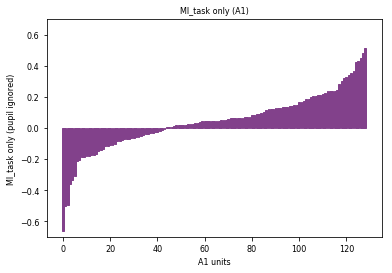

In [62]:
plt.figure()
plt.bar(x_axis_A1, df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'], color = color_b, edgecolor = color_b) 
plt.ylim((-0.7,0.7))
plt.xlabel('A1 units')
plt.ylabel('MI_task only (pupil ignored)')
plt.title('MI_task only (A1)')
#plt.savefig('MI_task_only_A1.pdf')

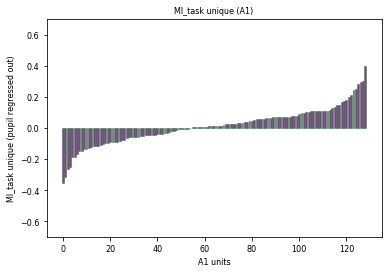

In [63]:
plt.figure()
plt.bar(x_axis_A1, df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], color = color_b, 
        edgecolor = color_p, linewidth=0.5) 
plt.ylim((-0.7,0.7))
plt.xlabel('A1 units')
plt.ylabel('MI_task unique (pupil regressed out)')
plt.title('MI_task unique (A1)')
#plt.savefig('MI_task_unique_A1.pdf')

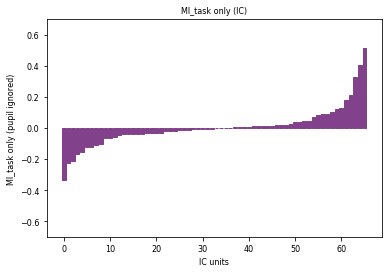

In [64]:
plt.figure()
plt.bar(x_axis_IC, df_MI_only_sorted.loc[full_model & is_active & (ICC | ICX), 'MIbeh_only'], color = color_b, edgecolor = color_b) 
plt.ylim((-0.7,0.7))
plt.xlabel('IC units')
plt.ylabel('MI_task only (pupil ignored)')
plt.title('MI_task only (IC)')
#plt.savefig('MI_task_only_IC.pdf')

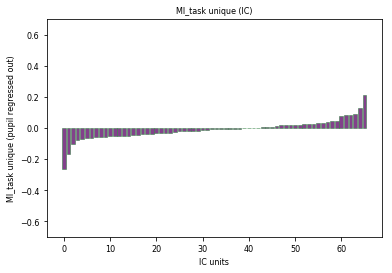

In [65]:
plt.figure()
plt.bar(x_axis_IC, df_MI_unique_sorted.loc[full_model & is_active & (ICC | ICX), 'MIbeh_unique'], color = color_b, 
        edgecolor = color_p, linewidth=0.5) 
plt.ylim((-0.7,0.7))
plt.xlabel('IC units')
plt.ylabel('MI_task unique (pupil regressed out)')
plt.title('MI_task unique (IC)')
#plt.savefig('MI_task_unique_IC.pdf')

In [66]:
# To quantify differences in modulation without the confounding element of sign let's do 
# (MItask only - MItask unique) * sign((MItask only+MItask unique)/2)
# and calculate how much that differs from zero

# A1
signed_diff_A1 = (df.loc[full_model & is_active & A1, 
                  'MIbeh_only']-df.loc[full_model & is_active & A1, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & A1, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & A1, 
                                                                                                 'MIbeh_only'])/2)

# A1 onBF
signed_diff_A1_onBF = (df.loc[full_model & is_active & A1 & onBF, 
                  'MIbeh_only']-df.loc[full_model & is_active & A1 & onBF, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & A1 & onBF, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & A1 & onBF, 
                                                                                                 'MIbeh_only'])/2)

# A1 offBF
signed_diff_A1_offBF = (df.loc[full_model & is_active & A1 & offBF, 
                  'MIbeh_only']-df.loc[full_model & is_active & A1 & offBF, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & A1 & offBF, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & A1 & offBF, 
                                                                                                 'MIbeh_only'])/2)


# IC all
signed_diff_IC = (df.loc[full_model & is_active & (ICC | ICX), 
                  'MIbeh_only']-df.loc[full_model & is_active & (ICC | ICX), 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & (ICC | ICX), 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & (ICC | ICX), 
                                                                                                 'MIbeh_only'])/2)


# IC onBF
signed_diff_IC_onBF = (df.loc[full_model & is_active & (ICC | ICX) & onBF, 
                  'MIbeh_only']-df.loc[full_model & is_active & (ICC | ICX) & onBF, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & (ICC | ICX) & onBF, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & (ICC | ICX) & onBF, 
                                                                                                 'MIbeh_only'])/2)

# IC onBF
signed_diff_IC_offBF = (df.loc[full_model & is_active & (ICC | ICX) & offBF, 
                  'MIbeh_only']-df.loc[full_model & is_active & (ICC | ICX) & offBF, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & (ICC | ICX) & offBF, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & (ICC | ICX) & offBF, 
                                                                                                 'MIbeh_only'])/2)


# ICC
signed_diff_ICC = (df.loc[full_model & is_active & ICC, 
                  'MIbeh_only']-df.loc[full_model & is_active & ICC, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & ICC, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & ICC, 
                                                                                                 'MIbeh_only'])/2)

# ICX
signed_diff_ICX = (df.loc[full_model & is_active & ICX, 
                  'MIbeh_only']-df.loc[full_model & is_active & ICX, 
                                         'MIbeh_unique']) * np.sign((df.loc[full_model & is_active & ICX, 
                                                                          'MIbeh_unique']+df.loc[full_model & is_active & ICX, 
                                                                                                 'MIbeh_only'])/2)

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

Parameters:

**x** : array_like  
The first set of measurements.

**y** : array_like, optional  
The second set of measurements. If y is not given, then the x array is considered to be the differences between the two sets of measurements.

**zero_method** : string, {“pratt”, “wilcox”, “zsplit”}, optional

    “pratt”:
        Pratt treatment: includes zero-differences in the ranking process (more conservative)
        
    “wilcox”:
        Wilcox treatment: discards all zero-differences
        
    “zsplit”:
        Zero rank split: just like Pratt, but spliting the zero rank between positive and negative ones

**correction** : bool, optional  
If True, apply continuity correction by adjusting the Wilcoxon rank statistic by 0.5 towards the mean value when computing the z-statistic. Default is False.

Returns:

T : float  
The sum of the ranks of the differences above or below zero, whichever is smaller.

p-value : float  
The two-sided p-value for the test.


In [67]:
print(sci.wilcoxon(signed_diff_A1, zero_method='pratt'))
print(sci.wilcoxon(signed_diff_ICC, zero_method='pratt'))
print(sci.wilcoxon(signed_diff_ICX, zero_method='pratt'))

WilcoxonResult(statistic=1469.0, pvalue=1.5334108209836256e-10)
WilcoxonResult(statistic=50.0, pvalue=0.12209548134133213)
WilcoxonResult(statistic=431.0, pvalue=0.10733727053148487)


In [68]:
print(sci.ranksums(signed_diff_ICC, signed_diff_ICX))
print(sci.ranksums(signed_diff_A1_onBF, signed_diff_A1_offBF))
print(sci.ranksums(signed_diff_IC_onBF, signed_diff_IC_offBF))

RanksumsResult(statistic=0.11518245674418136, pvalue=0.90830050361139225)
RanksumsResult(statistic=0.12085382706823943, pvalue=0.90380681467785573)
RanksumsResult(statistic=-1.0760944819572011, pvalue=0.28188500325964871)


In [69]:
print(sci.wilcoxon(abs(df.loc[full_model & is_active & A1, 'MIbeh_only']), abs(df.loc[full_model & is_active & A1, 'MIbeh_unique']), 
             zero_method='wilcox'))
print(sci.wilcoxon(abs(df.loc[full_model & is_active & ICC, 'MIbeh_only']), abs(df.loc[full_model & is_active & ICC, 'MIbeh_unique']), 
             zero_method='wilcox'))
print(sci.wilcoxon(abs(df.loc[full_model & is_active & ICX, 'MIbeh_only']), abs(df.loc[full_model & is_active & ICX, 'MIbeh_unique']), 
             zero_method='wilcox'))

WilcoxonResult(statistic=1361.0, pvalue=2.8160144111142193e-11)
WilcoxonResult(statistic=48.0, pvalue=0.10243990540645082)
WilcoxonResult(statistic=420.0, pvalue=0.084870518649555679)


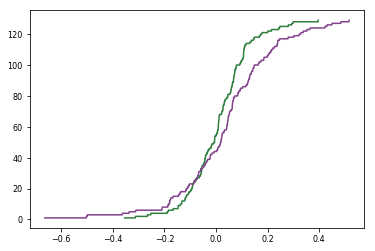

In [70]:
# Cumulative distributions of MIbeh only and MIbeh unique for A1
values_u, base_u = np.histogram(df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], bins=1000)
cumulative_u = np.cumsum(values_u)
values_o, base_o = np.histogram(df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'], bins=1000)
cumulative_o = np.cumsum(values_o)
plt.plot(base_u[:-1], cumulative_u, c=color_p)
plt.plot(base_o[:-1], cumulative_o, c=color_b)
#plt.savefig('cum_MIu_MIo_A1.pdf')

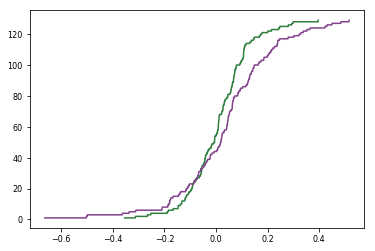

In [71]:
# Cumulative distributions of MIbeh only and MIbeh unique for A1
values_u, base_u = np.histogram(df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], bins=1000)
cumulative_u = np.cumsum(values_u)
values_o, base_o = np.histogram(df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'], bins=1000)
cumulative_o = np.cumsum(values_o)
plt.plot(base_u[:-1], cumulative_u, c=color_p)
plt.plot(base_o[:-1], cumulative_o, c=color_b)
#plt.savefig('cum_MIu_MIo_A1.pdf')

In [72]:
# Two-sample Kolmogorov-Smirnov A1
sci.ks_2samp(df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], 
             df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'])                                                                 

Ks_2sampResult(statistic=0.21705426356589153, pvalue=0.0037409955965993073)

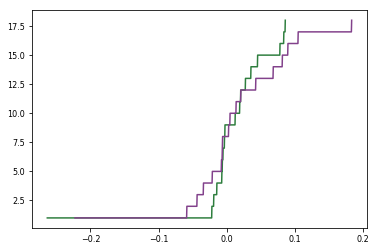

In [73]:
# Cumulative distributions of MIbeh only and MIbeh unique for ICC
values_u, base_u = np.histogram(df_MI_unique_sorted.loc[full_model & is_active & ICC, 'MIbeh_unique'], bins=1000)
cumulative_u = np.cumsum(values_u)
values_o, base_o = np.histogram(df_MI_only_sorted.loc[full_model & is_active & ICC, 'MIbeh_only'], bins=1000)
cumulative_o = np.cumsum(values_o)
plt.plot(base_u[:-1], cumulative_u, c=color_p)
plt.plot(base_o[:-1], cumulative_o, c=color_b)  
#plt.savefig('cum_MIu_MIo_IC.pdf')

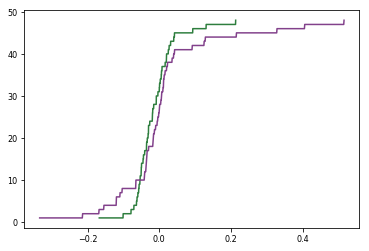

In [74]:
# Cumulative distributions of MIbeh only and MIbeh unique for ICX
values_u, base_u = np.histogram(df_MI_unique_sorted.loc[full_model & is_active & ICX, 'MIbeh_unique'], bins=1000)
cumulative_u = np.cumsum(values_u)
values_o, base_o = np.histogram(df_MI_only_sorted.loc[full_model & is_active & ICX, 'MIbeh_only'], bins=1000)
cumulative_o = np.cumsum(values_o)
plt.plot(base_u[:-1], cumulative_u, c=color_p)
plt.plot(base_o[:-1], cumulative_o, c=color_b)  
#plt.savefig('cum_MIu_MIo_IC.pdf')